In [1]:
import sys
sys.path.append('..')
from src.data.docx  import read_docx,process_docx,find_content
import glob
import json
import os
import pandas as pd
import ast
import warnings
warnings.filterwarnings("ignore")
from src.models.pipeline import pipeline
from functools import reduce
import heapq
from gensim.corpora import Dictionary
from gensim import models
from gensim import similarities
import re
import statistics
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# READ BOOKS OF VIDEOS

In [2]:
'''Defining CONSTS'''
docx_path = '../data/raw/docx'
groundbase_dir = '../data/raw/groundbase'
transcripts_dir = os.path.join(groundbase_dir,'transcripts')
topic_dataset_path = os.path.join(groundbase_dir,'dataset.csv')
transcript_filespath = glob.glob(groundbase_dir + '/transcripts/*.json')

In [3]:
videos_ids = list(map(lambda fl: fl.split('\\')[-1].split('.')[0],glob.glob(docx_path + '/*')))

In [4]:
desired_videos =['7kLHJ-F33GI','RIawrYLVdIw','7snJ1mx1EMQ','zWg7U0OEAoE','tORLeHHtazM'] #['zWg7U0OEAoE','tORLeHHtazM'] #['7kLHJ-F33GI','RIawrYLVdIw','7snJ1mx1EMQ']
videos_ids = list(filter(lambda x: x in desired_videos,videos_ids))

In [5]:
#video_docx = [glob.glob(os.path.join(docx_path,vid + '/*.docx'))[0] for vid in videos_ids]
#docx_db =[read_docx(path) for path in video_docx]

In [6]:
f_read = {
    'statbook':'statbook',
    'Dsa':'Dsa'
}

docxs_chapter_keyword = {
    'statbook':'Topic',
    'Dsa': 'Chapter'
}

In [7]:
video_to_paper = {}
paper_content ={}
for vid in videos_ids:
    doc_path = glob.glob(os.path.join(docx_path,vid + '/*.docx'))[0]
    doc_name = doc_path.split('\\')[-1].split('.')[0]
    video_to_paper[vid] = doc_name    
    if doc_name not in paper_content.keys():    
        full_text,font_sizes = read_docx(doc_path)
        paper_content[doc_name] = find_content(f_read[doc_name],
                                               full_text,
                                               font_sizes,
                                               docxs_chapter_keyword[doc_name])

In [8]:
"""#transcript_filespath
#videos_ids
from docx import *
word_document = Document(doc_path)
p_sent = re.compile('\w+')
full_text = []
font_sizes = []
for para in word_document.paragraphs:
    for i,run in enumerate(para.runs):        
        matching = p_sent.match(run.text)

        # see if there is a number or letter ( it is not a trash)
        if matching is not None and run.text is not None and run.font.size is not None:
                full_text.append(re.sub('[\t\n\b\r]','',run.text))
"""

"#transcript_filespath\n#videos_ids\nfrom docx import *\nword_document = Document(doc_path)\np_sent = re.compile('\\w+')\nfull_text = []\nfont_sizes = []\nfor para in word_document.paragraphs:\n    for i,run in enumerate(para.runs):        \n        matching = p_sent.match(run.text)\n\n        # see if there is a number or letter ( it is not a trash)\n        if matching is not None and run.text is not None and run.font.size is not None:\n                full_text.append(re.sub('[\t\n\x08\r]','',run.text))\n"

# RESTORE RESULTS FROM TRAINING

In [9]:
'''Select transcript for only wanted videos'''
transcript_filespath = list(filter(lambda x: x.split('\\')[-1].split('.')[0] in videos_ids,transcript_filespath))

'''Read the transcript'''
transcripts_jsons = {}
for fl in transcript_filespath:
    with open(fl,encoding="utf8") as f:
        transcript =ast.literal_eval(f.read()) #json.load(f)
        vid = fl.split('\\')[-1].split('.')[0]
        #print(vid)
        transcripts_jsons[vid] = transcript
#print(transcripts_jsons)

'''Read the videos metadata to perform on them the segmentation'''
df_videos = pd.read_csv(topic_dataset_path)

''' Transfer topic shifts time to seconds units instead HH:MM:SS'''
def topic_shifts_seconds(topic_shifts):
    tp_shift_sec=[]
    for tp in topic_shifts:
        intervals = tp.split(':')
        seconds = int(intervals[2])
        minutes = int(intervals[1]) * 60
        hours = int(intervals[0]) * 60 *60
        tp_shift_sec.append(seconds + minutes + hours)
    return tp_shift_sec
for video_id in transcripts_jsons.keys():    
    df_videos.at[df_videos['video id'] == video_id,'topic shifts(ends)'] =\
    topic_shifts_seconds(\
                         df_videos[df_videos['video id'] == \
                                   video_id]['topic shifts(ends)'])
    
    
'''Get parameters from training'''
df_results = pd.read_csv('../data/processed/bayesian_opt/results.csv')
n_largest_res = 3
pipeline_results = df_results[df_results['video'].isin(videos_ids)]\
                .groupby('video')[['video','workflow','params','max_target']]\
                .apply(lambda grp: grp.nlargest(n_largest_res,'max_target')).values.tolist()
#pipeline_results = pipeline_results[2:] 

In [10]:
pipeline_results

[['7kLHJ-F33GI',
  'sliding_window-tfidf-cosine-median_(3,3)-spectral_clustering',
  "{'n_clusters': 18.0, 'sim_thresh': 0.6, 'step_size': 10.0, 'window_size': 150.0}",
  0.8181818181818182],
 ['7kLHJ-F33GI',
  'sliding_window-tfidf-cosine-None-spectral_clustering',
  "{'n_clusters': 14.502132028215444, 'sim_thresh': 0.5160973480326474, 'step_size': 10.005718740867245, 'window_size': 59.30323444213917}",
  0.7272727272727273],
 ['7kLHJ-F33GI',
  'sliding_window-tfidf-cosine-None-spectral_clustering',
  "{'n_clusters': 12.880535344902679, 'sim_thresh': 0.32770157843063935, 'step_size': 19.313010568883545, 'window_size': 64.9228945155962}",
  0.7272727272727273],
 ['7snJ1mx1EMQ',
  'sliding_window-tfidf-cosine-median_(2,2)-spectral_clustering',
  "{'n_clusters': 16.432431412456257, 'sim_thresh': 0.3000063890009115, 'step_size': 59.99514192872911, 'window_size': 21.1099397077962}",
  0.8571428571428571],
 ['7snJ1mx1EMQ',
  'sliding_window-tfidf-cosine-median_(3,3)-spectral_clustering',
  

In [11]:
def boundryevaluation(curresults,ground_base,accurrcy_shift = 30):
        true_positive = 0
        false_negative = 0
        false_positive = 0 
        true_positive_list_debug = []
        #false_negative_list_debug = []
        false_positive_list_debug = []
        results = curresults[:]
        
        
        #print('curresults %s' %(curresults))
        #print('ground_base %s ' %(ground_base))
        
        for grb in ground_base:
            is_false_positive = True
            for res in results:     
                if abs(res - grb) < accurrcy_shift:
                    is_false_positive = False
                    true_positive_list_debug.append(res)
                    true_positive+=1
                    results.remove(res)
                    break   
            if is_false_positive:
                false_positive_list_debug.append(grb)
                false_positive+=1
                
        #print("TP: " + str(true_positive_list_debug))
        #print("FP: " + str(false_positive_list_debug))
        #print("FN: " + str(curresults))
        #print('true_positive : %s ' %(true_positive))
        false_negative = len(results) # make sure the true positive are removed from here 
        recall_rate = true_positive/(true_positive + false_negative )
        precision_rate = true_positive/(true_positive + false_positive)
        #print("TP: %s , FP: %s, FN: %s" %(true_positive,false_positive,false_negative))
        #print("precision rate : %s, recall rate : %s " % (precision_rate,recall_rate))
        return precision_rate

In [18]:
videos_division = {}

for vid in videos_ids:
    vid_results = list(filter(lambda x: x[0] == vid,pipeline_results))
    max_precision = 0
    vid_words = None
    vid_shifts = None
    for result in vid_results:
        '''From the get optimized by bayesian we get that for the video '''
        vid = result[0]
        params = ast.literal_eval(result[2]) #{'n_clusters': 18, 'sim_thresh': 0.6, 'step_size': 49, 'window_size': 150}
        #print(params)
        for key in ['n_clusters','step_size','window_size']:
            params[key] = int(params[key])# - 1
        workflow = result[1] #'sliding_window-tfidf-cosine-median_(3,3)-spectral_clustering'
        
        shifts = df_videos.loc[df_videos['video id'] == vid,'topic shifts(ends)'].values.tolist()
        groundbase = shifts[:-1]
        transcripts = transcripts_jsons[vid]
        #print(grounbase)
        _pipeline = workflow.split('-')
        filter_type = None
        mask_shape = None
        filtering = _pipeline[3]
        if filtering != 'None':
            filter_type = filtering.split('_')[0]
            mask_shape = ast.literal_eval(filtering.split('_')[1])
        '''This running may not work at first time do not give up and run it couple of times'''

        '''print('Running the following %s for video %s with params %s %s %s'
              %(workflow, vid,params,filter_type,mask_shape))'''
        #print(vid_results[1])
        #print(str(filter_type) + " " + str(mask_shape))
        shift_times,topic_words = (None,None)
        n_trials = 5
        while shift_times is None and topic_words is None and n_trials > 0:
            print('##################################################')
            print("running trial %s for vid %s desired precision %s "%(n_trials,vid,result[3]))
            n_trials= n_trials - 1
            shift_times,topic_words = pipeline.run_for_baye(groundbase,
                                                            transcripts,
                                                            slicing_method='sliding_window',
                                                            window_size=params['window_size'],#59
                                                            step_size_sd= params['step_size'], #10
                                  vector_method='tfidf',vectorizing_params=None,
                                  similarity_method='cosine',
                                  filter_params={"filter_type":filter_type,
                                                 "mask_shape":mask_shape,
                                                 "sim_thresh": params['sim_thresh'], #0.5160973480326474 
                                                 "is_min_thresh":True
                                                 },
                                 clustering_params={
                                         'algorithm':'spectral_clustering',
                                         'n_clusters':params['n_clusters'] #14
                                         },
                                        accurrcy_shift=30,
                                        return_value='division') or (None,None)

            if shift_times is not None:
                pr = boundryevaluation(shift_times,groundbase,accurrcy_shift=30)
                print("output precision %s " %(pr))
                
                if pr > max_precision:
                    print("new high percision caught")
                    max_precision = pr 
                    vid_words = topic_words
                    shift_times.append('end')
                    vid_shifts = shift_times 
                if pr < result[3]:
                    shift_times,topic_words = (None,None)    

    videos_division[vid] = {'topic_words':vid_words,'topic_shift':vid_shifts}

##################################################
running trial 5 for vid 7kLHJ-F33GI desired precision 0.8181818181818182 
output precision 0.45454545454545453 
new high percision caught
##################################################
running trial 4 for vid 7kLHJ-F33GI desired precision 0.8181818181818182 
output precision 0.45454545454545453 
##################################################
running trial 3 for vid 7kLHJ-F33GI desired precision 0.8181818181818182 
output precision 0.45454545454545453 
##################################################
running trial 2 for vid 7kLHJ-F33GI desired precision 0.8181818181818182 
output precision 0.45454545454545453 
##################################################
running trial 1 for vid 7kLHJ-F33GI desired precision 0.8181818181818182 
output precision 0.36363636363636365 
##################################################
running trial 5 for vid 7kLHJ-F33GI desired precision 0.7272727272727273 
output precision 0.636363636363636

In [19]:
#videos_division

# EXTRACT MAIN CHAPTERS OF BOOKS AND ORAGANIZE THE PAPER AS DIFFERENT DOCUMENTS GROUPS

In [20]:
paper_content[doc_name].keys()

dict_keys(['corpus', 'titles', 'main titles'])

In [21]:
'''Find the following for each paper:
    1) main chapter title index. for example [10,15....]
    2) range of subsection within each main chapter . for example [(0,9),(11,14)...]
    
    '''

paper_mainchapter_indexes = {}
paper_sec_within_main_indexes = {}
paper_mains_as_one_doc = {}
paper_subsec_as_one_doc = {}

for doc_name in paper_content.keys():
    '''Find the main chapter indexes in the list of the overall titles'''
    mainchapter_indexes = [paper_content[doc_name]['titles'].index(ch_title)
                           for ch_title in paper_content[doc_name]['main titles']]
    '''Find the subsection indexes range within each main chapter '''
    subsec_mainchapter_indexes = [range(mainchapter_indexes[index],mainchapter_indexes[index + 1])
                                  for index in range(len(mainchapter_indexes) - 1)]
    subsec_mainchapter_indexes.append(range(mainchapter_indexes[-1],
                                            len(paper_content[doc_name]['titles'])))
    paper_mainchapter_indexes[doc_name] = mainchapter_indexes
    paper_sec_within_main_indexes[doc_name] = subsec_mainchapter_indexes
    
    
    '''Making each chapter as a one documents'''
    
    '''Union all the documents in a section into single document'''
    paper_subsec_as_one_doc[doc_name] = [list(reduce(lambda doc,acc:doc + acc,sec,[]))
                                         for sec in paper_content[doc_name]['corpus']]
    '''Union all the sub section in a main chapter into one document'''
    paper_mains_as_one_doc[doc_name] = [list(reduce(lambda acc,s_i:
                                                    paper_subsec_as_one_doc[doc_name][s_i]+acc,subsec_indexes,[]))
                                        for subsec_indexes in paper_sec_within_main_indexes[doc_name]]

In [22]:
'''Debug'''
"""
print(paper_content['statbook']['main titles'])
print((paper_content['statbook']['titles']))
print(len(paper_content['statbook']['titles']))# 
print(len(paper_content['statbook']['corpus']))#members of each element:section corpus
print(len(paper_content['statbook']['corpus'][0]))#members of each element: documents
print(len(paper_content['statbook']['corpus'][0][0])) #of each element words
print(paper_sec_within_main_indexes['statbook'])


#debug
print(sum([len(paper_subsec_as_one_doc['statbook'][s]) for s in range(0,10)]))
print(len(paper_mains_as_one_doc['statbook'][0]))
print(len(paper_mains_as_one_doc['statbook']))



"""
"""#print(len(paper_subsec_as_one_doc['statbook']))
print((subsec_mainchapter_indexes))
print(len(paper_content['Dsa']['titles']))
print(len(paper_subsec_as_one_doc[doc_name]))
print(len(paper_sec_within_main_indexes[doc_name]))
print(paper_content['Dsa']['titles'][-1])
print(paper_subsec_as_one_doc[doc_name][-2])
"""
"""print(paper_content['Dsa']['main titles'][0])
print(len(paper_mains_as_one_doc['Dsa'][0][0]))
print((paper_mains_as_one_doc['Dsa'][0][0]))
#print(len(paper_sec_within_main_indexes['Dsa'][0][0]))
print(len(paper_subsec_as_one_doc['Dsa'][0]))
print((paper_subsec_as_one_doc['Dsa'][0][0]))
print(len(videos_division['tORLeHHtazM']['topic_words'][0][0]))
print((videos_division['tORLeHHtazM']['topic_words'][0][0]))"""

#paper_content['Dsa']['corpus']

"print(paper_content['Dsa']['main titles'][0])\nprint(len(paper_mains_as_one_doc['Dsa'][0][0]))\nprint((paper_mains_as_one_doc['Dsa'][0][0]))\n#print(len(paper_sec_within_main_indexes['Dsa'][0][0]))\nprint(len(paper_subsec_as_one_doc['Dsa'][0]))\nprint((paper_subsec_as_one_doc['Dsa'][0][0]))\nprint(len(videos_division['tORLeHHtazM']['topic_words'][0][0]))\nprint((videos_division['tORLeHHtazM']['topic_words'][0][0]))"

# FIND CORRELATION BETWEEN MAIN CHAPTERES AND FOUNDED TOPICS IN THE VIDEO 

In [23]:
def find_top_words_of_topic(topic_words,chapter_titles=None):
    for tp_i,tp_words in enumerate(topic_words):
        #
        raw_text = ' '.join(tp_words)
        myvectorizer = CountVectorizer()
        mytf = myvectorizer.fit_transform([raw_text]).toarray()
        #print(mytf)
        maxes = heapq.nlargest(3,mytf[0])
        indexes = []
        for i,bal in enumerate(mytf[0]):
            if bal in maxes:
                indexes.append(i)
        ws = [myvectorizer.get_feature_names()[_] for i,_ in enumerate(indexes)]
        
        if chapter_titles is None:
            print('top words for topic %s are %s' %(tp_i,ws))
        else:
            print('top words for topic %s are %s' %(chapter_titles[tp_i],ws))

In [24]:
'''Calculate the whole corpus of the video and the books as one raw text'''

'Calculate the whole corpus of the video and the books as one raw text'

In [25]:
def get_topic_chapter_corr_tfidf(paper_name,book_chapters,
                                 vid_topics_words,vid_topics_shift,
                                 dispaly_titles):
    raw_book_video = []
    for tp_vid in vid_topics_words:
        raw_book_video = raw_book_video + tp_vid
    
    for ch in book_chapters:
        raw_book_video = raw_book_video + ch

    # creating dictionary of all of the words in the corpus of the video and the paper
    dictionary = Dictionary([raw_book_video])
    whole_corpus = vid_topics_words + book_chapters
    bgw_corpus = [dictionary.doc2bow(doc) for doc in whole_corpus]
    tf_idf_model = models.TfidfModel(bgw_corpus)
    bgw_chapter = [dictionary.doc2bow(doc) for doc in book_chapters]
    index_sim = similarities.SparseMatrixSimilarity(tf_idf_model[bgw_chapter],
                                                    num_features=len(dictionary))
    bgw_vids = [dictionary.doc2bow(doc) for doc in vid_topics_words]
    correlation = [[s for s in index_sim[tf_idf_model[doc]]] for doc in bgw_vids]
    
    
    # find the top n words in the topic (in the video)
    '''print('$$$$$$$$$$$$$$top words of video topic$$$$$$$$$$$$$$')
    find_top_words_of_topic(videos_division[vid]['topic_words'])
    print('$$$$$$$$$$$$$$top words of book chapters$$$$$$$$$$$$$$')
    find_top_words_of_topic(book_chapters,chapter_titles=dispaly_titles)'''
    
    
    
    # normalizing the correlation between each topic and chapter 
    for i_t in range(len(correlation)):
        sum_ = sum(correlation[i_t])
        for ch_index in range(len(correlation[i_t])):
            correlation[i_t][ch_index] = correlation[i_t][ch_index]/sum_
    
    corr_as_row = reduce(lambda x,y: x+y,correlation,[] ) # to get the global max in min
    sns.heatmap(correlation,vmin=min(corr_as_row),vmax=max(corr_as_row))
    plt.show()
    
    
    
    # find the cha
    ch_matching_top = []
    #print(len(correlation[0]))
    for i,corr in enumerate(correlation):
        
        #####################################3
        '''Consider make this code in pandas'''
        ####################################33
        
        max_cor = max(corr) # max correlation with that topic
        shift = vid_topics_shift[i]

        #ch_matching_top.append(paper_mainchapter_indexes[paper_name][corr.index(max_cor)])
        ch_matching_top.append(dispaly_titles[corr.index(max_cor)])
        
        print (" video_shift index %s at %s , chapter title %s ( index %s) " 
               %(i,
                 sec_to_min(shift),
                 dispaly_titles[corr.index(max_cor)],
                 corr.index(max_cor)
                 ))
    return ch_matching_top

def find_dominent_main_chapter(ch_tp_corr,titles):
    
    '''Find the frequency of each chapter'''
    chapter_matching_counts_max = [max([ch_tp_corr.count(ch) for ch in ch_tp_corr])]
    for max_count in chapter_matching_counts_max:
        #print("####### #######")
        '''Find the most frequent chapter'''
        #print(([ch for ch in ch_tp_corr if ch_tp_corr.count(ch) == max_count]))
        dominent_chapters = list(set([ch for ch in ch_tp_corr if ch_tp_corr.count(ch) == max_count]))
        #print(dominent_chapters)
        
        # if we have absulote majority on topic
        if len(dominent_chapters) == 1:
            return dominent_chapters[0]
        else:
            '''####################################################3'''
            '''Think in the future maybe change this code ! making the decision based on something statistic else'''
            '''####################################################3'''
            # draw between topics, decide which one by taking this with the high variance
            index_winner = 0
            df_ch_corr =   pd.DataFrame.from_records(ch_tp_corr)
            for j_dom in range(len(dominent_chapters)):
                first = df_ch_corr.var()[titles.index(dominent_chapters[index_winner])]
                #print(first)
                second = df_ch_corr.var()[titles.index(dominent_chapters[j_dom])]
                #print(second)
                if first < second:
                    index_winner = j_dom
            return (dominent_chapters[index_winner])
        
        
def sec_to_min(seconds):
    if seconds == 'end':
        return 'end'
    return ("%02d:%02d"%(seconds//60,seconds%60))

################ 7kLHJ-F33GI ################


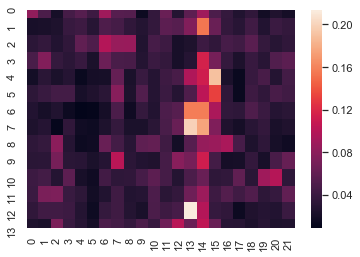

 video_shift index 0 at 02:26 , chapter title Random Variables and Distribution Functions ( index 6) 
 video_shift index 1 at 05:18 , chapter title Maximum Likelihood Estimation ( index 14) 
 video_shift index 2 at 08:55 , chapter title Random Variables and Distribution Functions ( index 6) 
 video_shift index 3 at 11:56 , chapter title Maximum Likelihood Estimation ( index 14) 
 video_shift index 4 at 15:05 , chapter title Interval Estimation ( index 15) 
 video_shift index 5 at 18:30 , chapter title Interval Estimation ( index 15) 
 video_shift index 6 at 20:47 , chapter title Unbiased Estimation ( index 13) 
 video_shift index 7 at 24:16 , chapter title Unbiased Estimation ( index 13) 
 video_shift index 8 at 27:46 , chapter title Simple Hypotheses ( index 16) 
 video_shift index 9 at 30:53 , chapter title Maximum Likelihood Estimation ( index 14) 
 video_shift index 10 at 33:57 , chapter title Goodness of Fit ( index 20) 
 video_shift index 11 at 37:13 , chapter title Maximum Likel

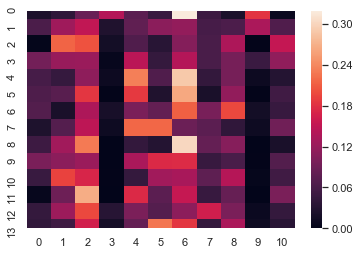

 video_shift index 0 at 02:26 , chapter title 15.6 Multidimensional Estimation ( index 6) 
 video_shift index 1 at 05:18 , chapter title 15.2 Examples ( index 2) 
 video_shift index 2 at 08:55 , chapter title 15.1 ( index 1) 
 video_shift index 3 at 11:56 , chapter title 15.4 Asymptotic Properties ( index 4) 
 video_shift index 4 at 15:05 , chapter title 15.6 Multidimensional Estimation ( index 6) 
 video_shift index 5 at 18:30 , chapter title 15.6 Multidimensional Estimation ( index 6) 
 video_shift index 6 at 20:47 , chapter title 15.6 Multidimensional Estimation ( index 6) 
 video_shift index 7 at 24:16 , chapter title 15.4 Asymptotic Properties ( index 4) 
 video_shift index 8 at 27:46 , chapter title 15.6 Multidimensional Estimation ( index 6) 
 video_shift index 9 at 30:53 , chapter title 15.6 Multidimensional Estimation ( index 6) 
 video_shift index 10 at 33:57 , chapter title 15.1 ( index 1) 
 video_shift index 11 at 37:13 , chapter title 15.2 Examples ( index 2) 
 video_shift

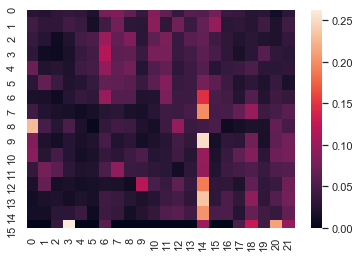

 video_shift index 0 at 02:48 , chapter title The Central Limit Theorem ( index 10) 
 video_shift index 1 at 04:38 , chapter title Interval Estimation ( index 15) 
 video_shift index 2 at 06:44 , chapter title Random Variables and Distribution Functions ( index 6) 
 video_shift index 3 at 09:12 , chapter title Random Variables and Distribution Functions ( index 6) 
 video_shift index 4 at 13:42 , chapter title Random Variables and Distribution Functions ( index 6) 
 video_shift index 5 at 15:21 , chapter title Overview of Estimation ( index 11) 
 video_shift index 6 at 17:20 , chapter title Maximum Likelihood Estimation ( index 14) 
 video_shift index 7 at 18:54 , chapter title Maximum Likelihood Estimation ( index 14) 
 video_shift index 8 at 21:03 , chapter title Displaying Data ( index 0) 
 video_shift index 9 at 23:06 , chapter title Maximum Likelihood Estimation ( index 14) 
 video_shift index 10 at 25:04 , chapter title Maximum Likelihood Estimation ( index 14) 
 video_shift inde

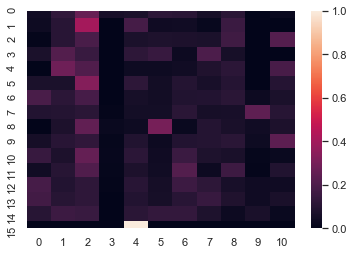

 video_shift index 0 at 02:48 , chapter title 15.2 Examples ( index 2) 
 video_shift index 1 at 04:38 , chapter title 15.2 Examples ( index 2) 
 video_shift index 2 at 06:44 , chapter title 15.10 Answers to Selected Exercises ( index 10) 
 video_shift index 3 at 09:12 , chapter title 15.1 ( index 1) 
 video_shift index 4 at 13:42 , chapter title 15.1 ( index 1) 
 video_shift index 5 at 15:21 , chapter title 15.2 Examples ( index 2) 
 video_shift index 6 at 17:20 , chapter title Maximum Likelihood Estimation ( index 0) 
 video_shift index 7 at 18:54 , chapter title 15.9 Technical Aspects ( index 9) 
 video_shift index 8 at 21:03 , chapter title 15.5 Comparison of Estimation Procedures ( index 5) 
 video_shift index 9 at 23:06 , chapter title 15.10 Answers to Selected Exercises ( index 10) 
 video_shift index 10 at 25:04 , chapter title 15.2 Examples ( index 2) 
 video_shift index 11 at 28:24 , chapter title 15.6 Multidimensional Estimation ( index 6) 
 video_shift index 12 at 30:35 , ch

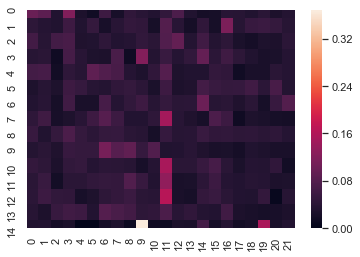

 video_shift index 0 at 02:24 , chapter title Producing Data ( index 3) 
 video_shift index 1 at 05:51 , chapter title Simple Hypotheses ( index 16) 
 video_shift index 2 at 08:52 , chapter title Method of Moments ( index 12) 
 video_shift index 3 at 11:44 , chapter title The Law of Large Numbers ( index 9) 
 video_shift index 4 at 14:21 , chapter title Conditional Probability and Independence ( index 5) 
 video_shift index 5 at 18:17 , chapter title Goodness of Fit ( index 20) 
 video_shift index 6 at 24:16 , chapter title Maximum Likelihood Estimation ( index 14) 
 video_shift index 7 at 28:02 , chapter title Overview of Estimation ( index 11) 
 video_shift index 8 at 30:52 , chapter title Producing Data ( index 3) 
 video_shift index 9 at 34:08 , chapter title Random Variables and Distribution Functions ( index 6) 
 video_shift index 10 at 37:19 , chapter title Overview of Estimation ( index 11) 
 video_shift index 11 at 42:04 , chapter title Overview of Estimation ( index 11) 
 vid

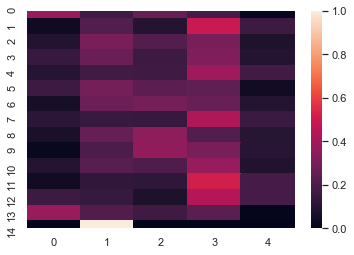

 video_shift index 0 at 02:24 , chapter title Overview of Estimation ( index 0) 
 video_shift index 1 at 05:51 , chapter title 12.3 Bayesian Statistics ( index 3) 
 video_shift index 2 at 08:52 , chapter title 12.1 ( index 1) 
 video_shift index 3 at 11:44 , chapter title 12.3 Bayesian Statistics ( index 3) 
 video_shift index 4 at 14:21 , chapter title 12.3 Bayesian Statistics ( index 3) 
 video_shift index 5 at 18:17 , chapter title 12.1 ( index 1) 
 video_shift index 6 at 24:16 , chapter title 12.2 Classical Statistics ( index 2) 
 video_shift index 7 at 28:02 , chapter title 12.3 Bayesian Statistics ( index 3) 
 video_shift index 8 at 30:52 , chapter title 12.2 Classical Statistics ( index 2) 
 video_shift index 9 at 34:08 , chapter title 12.2 Classical Statistics ( index 2) 
 video_shift index 10 at 37:19 , chapter title 12.3 Bayesian Statistics ( index 3) 
 video_shift index 11 at 42:04 , chapter title 12.3 Bayesian Statistics ( index 3) 
 video_shift index 12 at 45:36 , chapter 

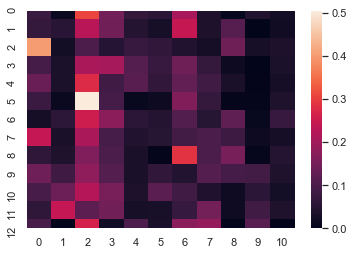

 video_shift index 0 at 04:09 , chapter title Binary Search Tree ( index 2) 
 video_shift index 1 at 07:01 , chapter title AVL Tree ( index 6) 
 video_shift index 2 at 08:32 , chapter title Introduction ( index 0) 
 video_shift index 3 at 11:04 , chapter title Binary Search Tree ( index 2) 
 video_shift index 4 at 12:27 , chapter title Binary Search Tree ( index 2) 
 video_shift index 5 at 13:28 , chapter title Binary Search Tree ( index 2) 
 video_shift index 6 at 14:36 , chapter title Binary Search Tree ( index 2) 
 video_shift index 7 at 15:47 , chapter title Introduction ( index 0) 
 video_shift index 8 at 32:09 , chapter title AVL Tree ( index 6) 
 video_shift index 9 at 36:18 , chapter title Binary Search Tree ( index 2) 
 video_shift index 10 at 38:54 , chapter title Binary Search Tree ( index 2) 
 video_shift index 11 at 42:34 , chapter title Linked Lists ( index 1) 
 video_shift index 12 at end , chapter title Binary Search Tree ( index 2) 
Binary Search Tree


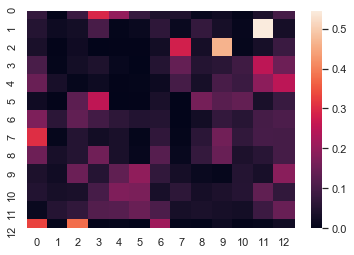

 video_shift index 0 at 04:09 , chapter title 3.3	Deletion ( index 3) 
 video_shift index 1 at 07:01 , chapter title 3.7.4	Breadth First ( index 11) 
 video_shift index 2 at 08:32 , chapter title 3.7.2	Postorder ( index 9) 
 video_shift index 3 at 11:04 , chapter title 3.7.4	Breadth First ( index 11) 
 video_shift index 4 at 12:27 , chapter title 3.8	Summary ( index 12) 
 video_shift index 5 at 13:28 , chapter title 3.3	Deletion ( index 3) 
 video_shift index 6 at 14:36 , chapter title Binary Search Tree ( index 0) 
 video_shift index 7 at 15:47 , chapter title Binary Search Tree ( index 0) 
 video_shift index 8 at 32:09 , chapter title 3.3	Deletion ( index 3) 
 video_shift index 9 at 36:18 , chapter title 3.5	Attaining a reference to a node ( index 5) 
 video_shift index 10 at 38:54 , chapter title 3.4	Finding the parent of a given node ( index 4) 
 video_shift index 11 at 42:34 , chapter title 3.5	Attaining a reference to a node ( index 5) 
 video_shift index 12 at end , chapter titl

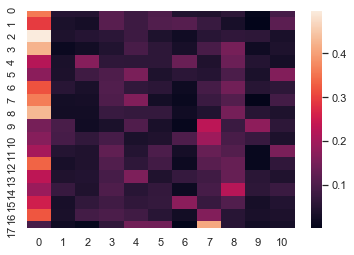

 video_shift index 0 at 05:42 , chapter title Introduction ( index 0) 
 video_shift index 1 at 08:52 , chapter title Introduction ( index 0) 
 video_shift index 2 at 13:00 , chapter title Introduction ( index 0) 
 video_shift index 3 at 16:05 , chapter title Introduction ( index 0) 
 video_shift index 4 at 20:27 , chapter title Introduction ( index 0) 
 video_shift index 5 at 23:57 , chapter title Introduction ( index 0) 
 video_shift index 6 at 27:44 , chapter title Introduction ( index 0) 
 video_shift index 7 at 30:56 , chapter title Introduction ( index 0) 
 video_shift index 8 at 33:59 , chapter title Introduction ( index 0) 
 video_shift index 9 at 37:07 , chapter title Sorting ( index 7) 
 video_shift index 10 at 41:06 , chapter title Sorting ( index 7) 
 video_shift index 11 at 45:39 , chapter title Introduction ( index 0) 
 video_shift index 12 at 49:10 , chapter title Introduction ( index 0) 
 video_shift index 13 at 53:36 , chapter title Introduction ( index 0) 
 video_shift

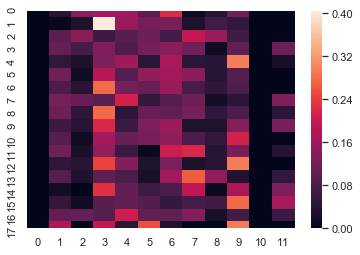

 video_shift index 0 at 05:42 , chapter title 1.3	Pseudocode ( index 6) 
 video_shift index 1 at 08:52 , chapter title 1.2.1	Big Oh notation ( index 3) 
 video_shift index 2 at 13:00 , chapter title 1.4	Tips for working through the examples ( index 7) 
 video_shift index 3 at 16:05 , chapter title 1.3	Pseudocode ( index 6) 
 video_shift index 4 at 20:27 , chapter title 1.6	Testing ( index 9) 
 video_shift index 5 at 23:57 , chapter title 1.2.1	Big Oh notation ( index 3) 
 video_shift index 6 at 27:44 , chapter title 1.2.1	Big Oh notation ( index 3) 
 video_shift index 7 at 30:56 , chapter title 1.2.2	Imperative programming language ( index 4) 
 video_shift index 8 at 33:59 , chapter title 1.2.1	Big Oh notation ( index 3) 
 video_shift index 9 at 37:07 , chapter title 1.2.1	Big Oh notation ( index 3) 
 video_shift index 10 at 41:06 , chapter title 1.6	Testing ( index 9) 
 video_shift index 11 at 45:39 , chapter title 1.4	Tips for working through the examples ( index 7) 
 video_shift ind

In [26]:
chapters_matching_topics = {}
for vid in videos_ids:
    print('################ %s ################' % (vid))
    paper_name = video_to_paper[vid]
    '''Finding the correlation between topic and main chapters'''
    main_matching_topic = get_topic_chapter_corr_tfidf(paper_name,
                                 paper_mains_as_one_doc[paper_name],
                                 videos_division[vid]['topic_words'],
                                 videos_division[vid]['topic_shift'],
                                 paper_content[paper_name]['main titles'])
    #print(main_matching_topic)
    '''Searching for the dominent main chapter '''
    '''titlesIndex = find_dominent_main_chapter(main_matching_topic,paper_content[paper_name]['main titles'])
    dominet_chapter = paper_content[paper_name]['titles'][titlesIndex]'''
    
    dominet_chapter =  find_dominent_main_chapter(main_matching_topic,paper_content[paper_name]['main titles'])
    
    print(dominet_chapter)
    
    '''Searching for each topic the most correlated 
       subsection to a topic within the dominent main chapter '''
    dom_main_cha_index = paper_content[paper_name]['main titles'].index(dominet_chapter)
    dom_subsec_text = [paper_subsec_as_one_doc[paper_name][s_i] for s_i in
                      paper_sec_within_main_indexes[paper_name][dom_main_cha_index]]
    dom_subsec_titles = [paper_content[paper_name]['titles'][tl]
                         for tl in paper_sec_within_main_indexes[paper_name][dom_main_cha_index]]
    
    subsec_matching_topic = get_topic_chapter_corr_tfidf(paper_name,
                                 dom_subsec_text,
                                 videos_division[vid]['topic_words'],
                                 videos_division[vid]['topic_shift'],
                                 dom_subsec_titles
                                    )
    
    